In [1]:
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance
import torch
#from training import register_esmart_wip,get_cfg,build_detection_test_loader
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader,build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.modeling import build_model
from detectron2 import model_zoo
from detectron2.structures import Boxes,Instances
import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
import cv2
import copy
from detectron2.layers import batched_nms
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer 

#embed_classwise = {}
#fea_path = "ood_distance/checkpoints/esmart/coco_features/gt/box"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [10]:
cfg = get_cfg()
#cfg.merge_from_file("/home/vaibhav/Desktop/stud/configs/BDD100k/stud_resnet.yaml")
#cfg = model_zoo.get_config(config_path="COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",trained=False)  # Use the appropriate config file
cfg.merge_from_file("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/finetune_bigdet_trained.yaml")
#cfg._BASE_ = "/home/mila/v/vaibhav.jade/scratch/intern/stud/configs/Base-RCNN-FPN.yaml"
#cfg.DATASETS.TEST = ("esmart_wip",)

cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/esmart/bigdet_finetune_on_esmart/model_final.pth"
#test_data_loader = build_detection_train_loader(cfg)

model = build_model(cfg)
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)


cfg.merge_from_file("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/bigdet_trained.yaml")
cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/faster_rcnn_r50_fpn_bigdet_8x.pth"

#cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/model_final_b275ba.pkl"
coco_model = build_model(cfg)
checkpointer = DetectionCheckpointer(coco_model)
checkpointer.load(cfg.MODEL.WEIGHTS)
coco_model.eval()
predictor = DefaultPredictor(cfg)

Config '/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/finetune_bigdet_trained.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Config '/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/bigdet_trained.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [11]:
model.eval()
model.requires_grad_(False)


GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [42]:
cfg.merge_from_file("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/finetune_bigdet_trained.yaml")
cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/esmart/bigdet_finetune_on_esmart/model_final.pth"
#cfg.merge_from_file("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/coco_trained.yaml")

#cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/model_final_b275ba.pkl"
#cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/faster_rcnn_r50_fpn_bigdet_8x.pth"
fine_predictor = DefaultPredictor(cfg)

Config '/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/finetune_bigdet_trained.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [12]:
image = cv2.imread("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/notebooks/montreal-construction.jpeg")
height, width = image.shape[:2]
num_classes = 12
magnitude = 0.01
aug = T.ResizeShortestEdge(
    [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
    )
im = aug.get_transform(image).apply_image(image)
im = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
im.to(device)

inputs = {"image": im, "height": height, "width": width}


/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


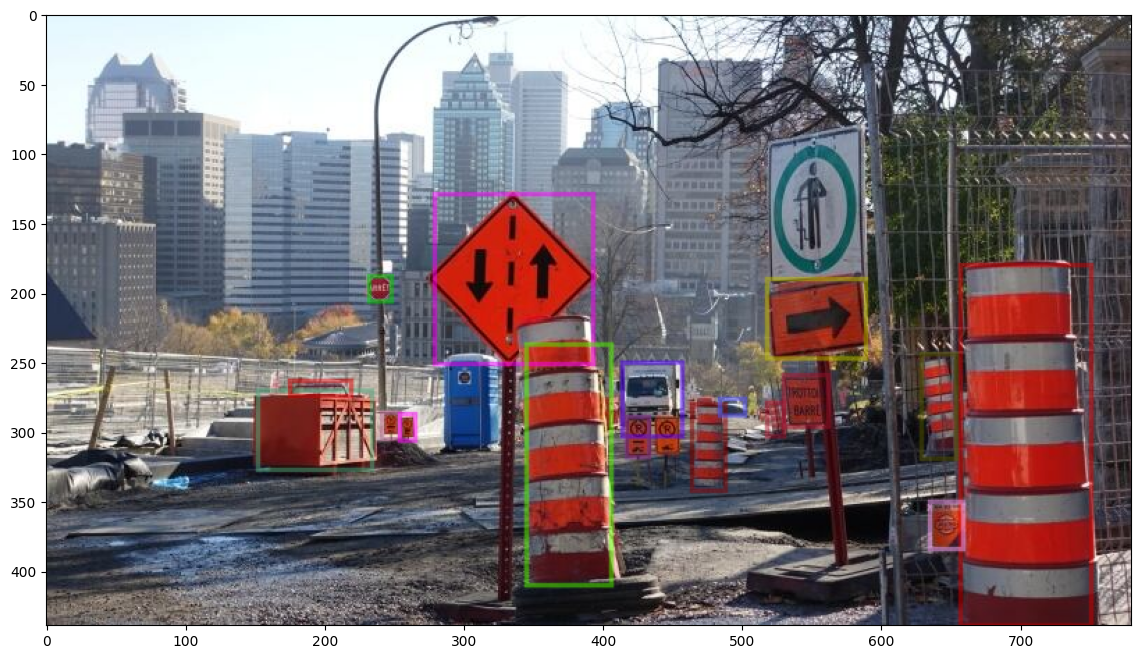

In [43]:
outputs = fine_predictor(image)
v_pred = Visualizer(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), None)
#v_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))
v_pred = v_pred.overlay_instances(
    boxes= outputs['instances'].pred_boxes.tensor.detach().cpu(),
    #labels = labels
    #labels = ["ood " if i==1 else "id " for i in predictions.pred_classes]
)
plt.figure(figsize = (14, 10))
plt.imshow(v_pred.get_image())

In [44]:
outputs

{'instances': Instances(num_instances=17, image_height=439, image_width=780, fields=[pred_boxes: Boxes(tensor([[464.1169, 280.3798, 488.2251, 342.5029],
         [278.7838, 128.7886, 393.3716, 251.4632],
         [231.7239, 188.4208, 247.6427, 206.1937],
         [657.1975, 180.3402, 750.6791, 439.0000],
         [483.5226, 276.2149, 502.2301, 287.9721],
         [345.0515, 236.9837, 406.1517, 409.6302],
         [175.3726, 262.5390, 219.1532, 274.1506],
         [629.0875, 243.6391, 654.0002, 318.8644],
         [413.9905, 249.8615, 457.2470, 303.2968],
         [529.9518, 259.4266, 561.6960, 295.7479],
         [635.3789, 350.3612, 658.8878, 384.0433],
         [151.5649, 270.4842, 234.0275, 327.0807],
         [416.9815, 289.2169, 433.0225, 317.9572],
         [517.6691, 189.8755, 589.2819, 246.6264],
         [253.8387, 286.8202, 265.2614, 305.6279],
         [518.1141, 278.7151, 529.5881, 303.4383],
         [241.3004, 285.6414, 253.8143, 305.3554]], device='cuda:0')), scores: ten

In [45]:
prop_preds = model([inputs])[0]
prop_preds

{'instances': Instances(num_instances=11, image_height=439, image_width=780, fields=[pred_boxes: Boxes(tensor([[274.2293, 132.5011, 392.7641, 251.0582],
         [659.1179, 176.7195, 751.5542, 439.0000],
         [463.2626, 274.4895, 488.6287, 341.9529],
         [333.9626, 216.5129, 412.6298, 435.3980],
         [627.4092, 247.9270, 656.6356, 317.5171],
         [482.0940, 275.9931, 503.2318, 288.8835],
         [482.2206, 277.2685, 504.3920, 312.4734],
         [230.6043, 188.1316, 249.0551, 205.5900],
         [407.6713, 247.7967, 456.8504, 299.6819],
         [517.4027, 191.0560, 588.4933, 245.6792],
         [522.3505, 243.5970, 567.8054, 301.7107]], device='cuda:0')), scores: tensor([0.9925, 0.9910, 0.9839, 0.9727, 0.8680, 0.8641, 0.8457, 0.7792, 0.6834,
         0.6623, 0.5965], device='cuda:0'), pred_classes: tensor([ 7,  7,  7,  7,  7,  2,  2,  9, 11,  7,  7], device='cuda:0')])}

In [46]:
v_pred = Visualizer(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), None)
#v_pred = v_pred.draw_instance_predictions(prop_preds["instances"].to("cpu"))
v_pred = v_pred.overlay_instances(
    boxes= prop_preds['instances'].pred_boxes.tensor.detach().cpu(),
    #labels = labelss
    #labels = ["ood " if i==1 else "id " for i in predictions.pred_classes]
)
plt.figure(figsize = (14, 10))
plt.imshow(v_pred.get_image())

In [107]:
def sample_estimator(embed_classwise,num_classes):
    classwise_mean = np.zeros((num_classes,embed_classwise[0][0].shape[0]),dtype='float32')
    precision = []
    X = None
    group_lasso = EmpiricalCovariance(assume_centered=False)
    for c in embed_classwise.keys():
        f_x = np.array(embed_classwise[c])
        classwise_mean[c] = f_x.mean(axis=0)
        f_x = f_x - classwise_mean[c][np.newaxis,:]
        if c == list(embed_classwise.keys())[0]:
             X = f_x
        else:
            np.concatenate((X,f_x),axis=0)
        ### finding inverse of covariance
    group_lasso.fit(X)
    precision = group_lasso.precision_
    #precision = np.array(precision)
   

    return torch.from_numpy(classwise_mean).float().to(device),torch.from_numpy(precision).float().to(device)

embed_classwise = {}
fea_path = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/esmart/bigdet_features/gt/box"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for im in os.listdir(fea_path):
    x = {}
    with open(os.path.join(fea_path,im), 'rb') as f:
        x = pickle.load(f)
        
    idx = 0
    for i in x['preds']:
        if embed_classwise.get(i.item()) == None:
            embed_classwise[i.item()] = [x['features'][idx].detach().cpu().numpy()]
        else:
            embed_classwise[i.item()].append(x['features'][idx].detach().cpu().numpy())
        idx += 1      

In [108]:
sample_mean,precision = sample_estimator(embed_classwise,12)

copy_model = copy.deepcopy(model)
copy_model.eval()
copy_model.requires_grad_(False)
sample_mean.requires_grad_(False)
precision.requires_grad_(False)

tensor([[ 5.1058e+01, -3.5692e-01, -2.3033e-01,  ..., -1.5094e+01,
          1.7381e+00,  8.6397e-01],
        [-3.5692e-01,  1.6909e+01, -1.1324e-01,  ..., -2.5914e+00,
         -5.6775e-02, -1.4783e-01],
        [-2.3033e-01, -1.1324e-01,  1.3866e+01,  ...,  3.4082e+00,
         -1.3629e+00, -2.5778e-02],
        ...,
        [-1.5094e+01, -2.5914e+00,  3.4082e+00,  ...,  4.9535e+03,
          2.5568e-01,  1.2560e+00],
        [ 1.7381e+00, -5.6775e-02, -1.3629e+00,  ...,  2.5568e-01,
          1.7502e+02, -1.3833e+00],
        [ 8.6397e-01, -1.4783e-01, -2.5778e-02,  ...,  1.2560e+00,
         -1.3833e+00,  1.5163e+01]], device='cuda:0')

In [109]:
def get_features(model, inputs, instances = None,is_inference=False):
    
    def hook(module, input, output):
                features.append(output)
    
    ### hooks to get feature maps from backbone 
    h = model.backbone.register_forward_hook(hook)
    features = []
    predictions = model([inputs])[0]
    h.remove()

    # Get detection instances
    if instances == None:
        instances = predictions['instances']

    # Get detected boxes and extract corresponding feature embeddings
    ### detaching predictions from computation graph
    if is_inference:
        pred_boxes = Boxes(torch.concat([instances,predictions['instances'].pred_boxes.tensor],dim=0))  # Prediction boxes (x1, y1, x2, y2)
    else:
        pred_boxes = Boxes(instances)
    roi_pooler = model.roi_heads.box_pooler  # ROI feature extractor
    feature_extractor = model.roi_heads.box_head

    pooled_features = roi_pooler([features[0][f] for f in model.roi_heads.in_features], [pred_boxes])
    roi_features = feature_extractor(pooled_features)

    return pred_boxes.tensor, roi_features,predictions



In [147]:

Mahalanobis = []
input_path = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/notebooks/deer_car_sign.jpg"
num_classes = 12
magnitude = 0.01

image = cv2.imread(input_path)
height, width = image.shape[:2]
num_classes = 12
magnitude = 0.01
aug = T.ResizeShortestEdge(
    [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
    )
inp_image = aug.get_transform(image).apply_image(image)
inp_image = torch.as_tensor(inp_image.astype("float32").transpose(2, 0, 1))
inp_image = inp_image.to(device).requires_grad_(True)

im = {"image": inp_image, "height": height, "width": width}

### forward pass and roi pooling features
### Warning! instances here is still connected to graph,
### pass it under no_grad() context or be careful    
# instances,out_features = get_features_for_proposals(model,im)

# out_nms = batched_nms(instances.proposal_boxes.tensor,instances.objectness_logits,torch.ones_like(instances.objectness_logits),0.5)
# min_idx = min(20,len(out_nms))
# prop_boxes = instances.proposal_boxes.tensor.detach()[out_nms[:min_idx]]
# out_features = out_features[out_nms[:min_idx]]

# compute Mahalanobis score
#coco_preds = predictor(image)
coco_preds =  coco_model([im])[0]

prop_boxes,out_features,predictions = get_features(model,im,coco_preds['instances'].pred_boxes.tensor.detach(),is_inference=True)
#prop_boxes,out_features = get_features(model,im,gt)    

gaussian_score = 0
out_features = torch.unsqueeze(out_features,1)
#sample_mean = torch.unsqueeze(sample_mean,0)
zero_f = out_features - torch.unsqueeze(sample_mean,0)     #shape b,n_c,1024
### (b,n_c,1024) x (1024,1024) x (b,1024,n_c)= (b,n_c,n_c)
gaussian_score = torch.matmul(torch.matmul(zero_f,precision), torch.transpose(zero_f,1,2))
### taking diag() of (n_c,n_c) matrices
gaussian_score = gaussian_score*torch.eye(num_classes,num_classes,device=device)
gaussian_score = -0.5*gaussian_score.sum(dim=-1)

### there's no need to calculate again as its the same calculation
loss = -(gaussian_score).max(dim=1)[0]

for l in range(len(loss)):
    if l == len(loss) - 1:
        model.zero_grad()
        #inp_image.grad = None
        loss[l].backward()
    else:
        model.zero_grad()
        inp_image.grad = None
        loss[l].backward(retain_graph=True)
    ### sign function on gradients
    gradient =  torch.ge(inp_image.grad, 0)
    gradient = (gradient.float() - 0.5) * 2

    ### scaling the gradient by image preprocessing std in original code, 
    ### not needed as its 1 in FasterRCNN, subject to specific case

    # gradient.index_copy_(1, torch.LongTensor([0]).cuda(), gradient.index_select(1, torch.LongTensor([0]).cuda()) / (model.pixel_std[0]))
    # gradient.index_copy_(1, torch.LongTensor([1]).cuda(), gradient.index_select(1, torch.LongTensor([1]).cuda()) / (model.pixel_std[1]))
    # gradient.index_copy_(1, torch.LongTensor([2]).cuda(), gradient.index_select(1, torch.LongTensor([2]).cuda()) / (model.pixel_std[2]))

    tempInputs = torch.add(inp_image, -magnitude, gradient)

    with torch.no_grad():

        _,noise_out_features,_ = get_features(copy_model,{"image": tempInputs, "height": height, "width": width},prop_boxes)

        noise_gaussian_score = 0
        noise_out_features = torch.unsqueeze(noise_out_features[l],0)
        noise_zero_f = noise_out_features - sample_mean.squeeze()     #shape b,n_c,1024
        ### (b,n_c,1024) x (1024,1024) x (b,1024,n_c)= (b,n_c,n_c)
        noise_gaussian_score = -0.5*torch.mm(torch.mm(noise_zero_f,precision), noise_zero_f.t()).diag()

        noise_gaussian_score = torch.max(noise_gaussian_score)
        Mahalanobis.append(noise_gaussian_score.cpu().numpy())

ood_preds = torch.tensor(np.asarray(Mahalanobis)) < -13000.0
ood_preds = ood_preds*1
final_preds = batched_nms(prop_boxes,torch.tensor(np.asarray(Mahalanobis)).abs().to(device),torch.ones_like(ood_preds),0.7)
print(ood_preds,final_preds,prop_boxes)
pred_instances = Instances((height,width))
pred_instances.pred_boxes = Boxes(prop_boxes)[final_preds]
pred_instances.pred_classes = (ood_preds + 1)[final_preds]
pred_instances.mahal_scores = torch.tensor(np.asarray(Mahalanobis))[final_preds]


/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


tensor([1, 1, 0, 1, 1, 1, 1, 1, 1]) tensor([6, 3, 4, 1, 5, 8], device='cuda:0') tensor([[1217.3044,  232.2666, 1289.8553,  290.9776],
        [1263.0089,  139.6281, 1330.4391,  161.1641],
        [ 879.9422,  218.8723, 1068.2861,  367.3663],
        [ 589.7483,  274.3015,  753.0431,  422.6306],
        [ 930.4583,  238.2945,  965.8836,  258.9135],
        [ 240.9055,   44.5381,  245.6703,   55.8393],
        [1218.3301,  232.5568, 1289.5071,  290.4248],
        [1263.2856,  139.7560, 1330.2454,  161.1396],
        [ 879.4822,  221.9532, 1071.9303,  367.6969]], device='cuda:0',
       grad_fn=<CatBackward0>)


In [148]:
prop_boxes,ood_preds,pred_instances,predictions

(tensor([[1217.3044,  232.2666, 1289.8553,  290.9776],
         [1263.0089,  139.6281, 1330.4391,  161.1641],
         [ 879.9422,  218.8723, 1068.2861,  367.3663],
         [ 589.7483,  274.3015,  753.0431,  422.6306],
         [ 930.4583,  238.2945,  965.8836,  258.9135],
         [ 240.9055,   44.5381,  245.6703,   55.8393],
         [1218.3301,  232.5568, 1289.5071,  290.4248],
         [1263.2856,  139.7560, 1330.2454,  161.1396],
         [ 879.4822,  221.9532, 1071.9303,  367.6969]], device='cuda:0',
        grad_fn=<CatBackward0>),
 tensor([1, 1, 0, 1, 1, 1, 1, 1, 1]),
 Instances(num_instances=6, image_height=668, image_width=1356, fields=[pred_boxes: Boxes(tensor([[1218.3301,  232.5568, 1289.5071,  290.4248],
         [ 589.7483,  274.3015,  753.0431,  422.6306],
         [ 930.4583,  238.2945,  965.8836,  258.9135],
         [1263.0089,  139.6281, 1330.4391,  161.1641],
         [ 240.9055,   44.5381,  245.6703,   55.8393],
         [ 879.4822,  221.9532, 1071.9303,  367.6969

In [149]:
labels = [" " for i in range(len(coco_preds['instances']))]
things_classes = np.array(["bicycle","bus","car","lane","lanes","motorcycle","person",
                        "roadwork_tcd","speed_limit","stop sign", "traffic light",
                        "truck"])
addon = things_classes[list(predictions['instances'].pred_classes.cpu())]
for i in range(len(addon)):
    labels.append(addon[i]+" "+"{:1.2f}".format(float(predictions['instances'].scores.cpu()[i])))

In [150]:
np.asarray(labels)[final_preds.cpu()], pred_instances.mahal_scores

(array(['car 1.00', ' ', ' ', ' ', ' ', 'car 0.99'], dtype='<U8'),
 tensor([-327340.3438, -164352.0938,  -61530.0625,  -56903.3516,  -23988.7090,
          -17907.6602]))

In [156]:
pred_instances.mahal_scores/(pred_instances.mahal_scores.sum())

tensor([0.5020, 0.2521, 0.0944, 0.0873, 0.0368, 0.0275])

In [151]:
v_pred = Visualizer(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), None)
v_pred = v_pred.overlay_instances(
    boxes= pred_instances.pred_boxes.tensor.detach().cpu(),
    #labels = labels
    labels = ["ood: "+score if i==2 else "id: "+score for i,score in zip(pred_instances.pred_classes,np.asarray(labels)[final_preds.cpu()])]
)
plt.figure(figsize = (14, 10))
plt.imshow(v_pred.get_image())

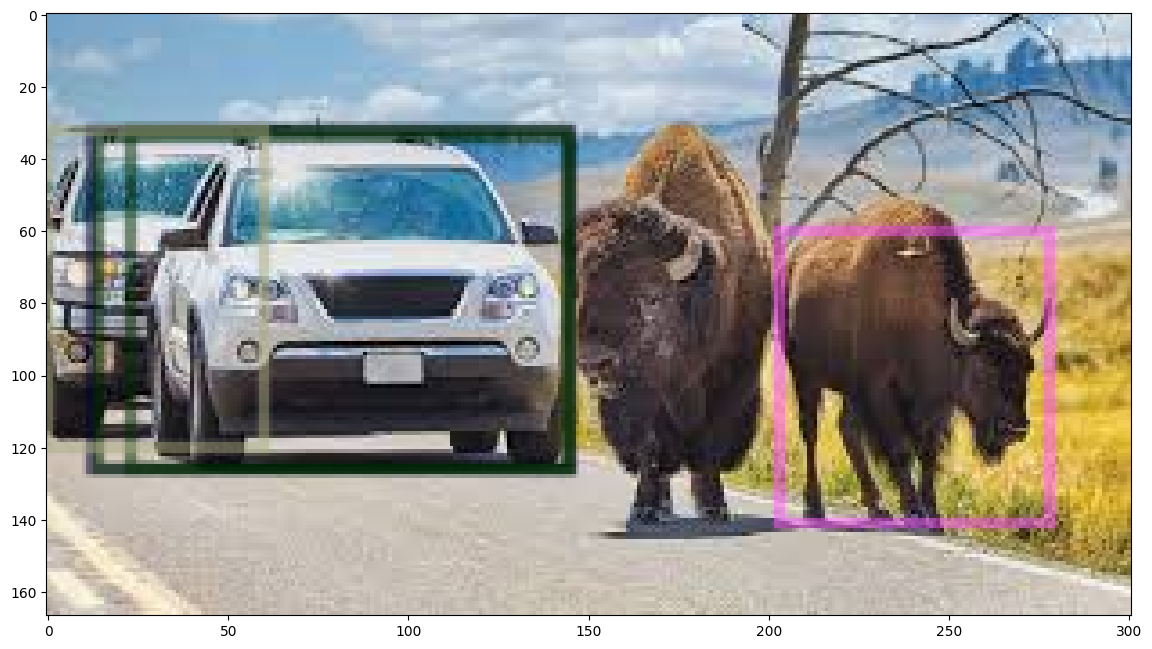

In [83]:
v_pred = Visualizer(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), None)
#v_pred = v_pred.draw_instance_predictions(prop_preds["instances"].to("cpu"))
v_pred = v_pred.overlay_instances(
    boxes= prop_boxes.detach().cpu()
    #pred_instances.pred_boxes.tensor.detach().cpu(),
    #labels = labelss
    #labels = ["ood "+str(score) if i==2 else "id "+str(score) for i,score in zip(pred_instances.pred_classes,pred_instances.mahal_scores)]
)
plt.figure(figsize = (14, 10))
plt.imshow(v_pred.get_image())

In [24]:
cfg

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': '/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/faster_rcnn_r50_fpn_bigdet_8x.pth', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 6}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'PO